In [25]:
!pip install casadi

import casadi as ca
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
from torch.utils.data import DataLoader, TensorDataset, random_split
import os
import fastprogress
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [26]:
def get_device(cuda_preference=True):
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: False ; cudnn available: False ; num devices: 0
Using device cpu
4 CPUs available


## Solving the optimal control problem

In [27]:
T = 5
dt = 0.5
no_samples = 50
sample_range = (-3,3)

# Define system dynamics for single integrator
def dynamics(x, u, dt):
    return x + dt * u

# Define running cost
def running_cost(x, u):
    #return 0.5 * u**2 + (x - 1.9)*(x - 1.0)*(x - 0.6)*(x + 0.5)*(x + 1.2)*(x + 2.1)
    return 0.5 * u**2 + (x - 2)**2*(x + 2)**2

def compute_trajectory(x0, optimal_actions, dt=dt):
    x_traj = [x0]
    x_current = x0
    cost = []
    for u in optimal_actions:
        cost.append(running_cost(x_current, u))
        x_current = dynamics(x_current, u, dt)
        x_traj.append(x_current)
    return np.array(x_traj), cost

# Set up CasADi optimization problem with finite time horizon
def solve_ocp(x0, T=T, dt=dt, u_min=-1, u_max=1):
    N = int(T / dt)  # Number of time steps

    # Define CasADi variables
    x = ca.MX.sym('x')
    u = ca.MX.sym('u')
    x_next = dynamics(x, u, dt)
    
    # Define cost function and constraints
    cost = 0
    constraints = []

    # Initial state
    x_current = x0

    # List to store control variables
    u_vars = []

    # Loop through time steps
    for t in range(N):
        u_var = ca.MX.sym(f'u_{t}')
        cost += running_cost(x_current, u_var)
        x_current = dynamics(x_current, u_var, dt)
        constraints.append(x_current)
        u_vars.append(u_var)

    # Define optimization problem
    opt_vars = ca.vertcat(*u_vars)
    nlp = {'x': opt_vars, 'f': cost, 'g': ca.vertcat(*constraints)}

    solver_opts = {
        'ipopt.print_level': 0,
        'print_time': False,
        'ipopt.sb': 'yes'  # This silences the solver completely
    }
    
    solver = ca.nlpsol('solver', 'ipopt', nlp, solver_opts)

    # Solve the problem
    sol = solver(lbg=-ca.inf, ubg=ca.inf, lbx=u_min, ubx=u_max)

    # Extract the optimal cost and actions
    optimal_cost = sol['f'].full().item()
    optimal_actions = sol['x'].full().flatten()
    return optimal_cost, optimal_actions

# Generate initial states
initial_states = np.linspace(sample_range[0], sample_range[1], no_samples)

# Solve OCPs and collect data
data = []
for x0 in initial_states:
    cost_opt, actions_opt = solve_ocp(x0)
    data.append((x0, cost_opt, actions_opt))

# Prepare data for training
states, costs, actions = zip(*data)
states = np.array(states)
costs = np.array(costs)
opt_actions = np.array(actions)

# Print collected data
print("Initial states:", states.shape)
print("Optimal costs:", costs.shape)
print("Optimal actions:", opt_actions.shape)


traj, c = compute_trajectory(states[0], opt_actions[0])

print(traj)
print(c)


Initial states: (50,)
Optimal costs: (50,)
Optimal actions: (50, 10)
[-3.         -2.5        -1.99999999 -1.81729736 -1.80997454 -1.80967625
 -1.80966409 -1.80966359 -1.80966357 -1.80966357 -1.80966357]
[286.2680000092841, 50.1495989403028, -3.5836396329153786, -5.819560283312672, -5.8223249866625055, -5.822329524777705, -5.82232953231432, -5.822329532326841, -5.822329532326863, -5.8223295323268625]


## Preparing the Dataset

In [28]:
def normalize(tensor, min_val, max_val):
    return 2 * (tensor - min_val) / (max_val - min_val) - 1

def denormalize(tensor, min_val, max_val):
    return (tensor + 1) * (max_val - min_val) / 2 + min_val

states = np.array(states).reshape(-1, 1)
costs = np.array(costs).reshape(-1, 1)

# Scaling the states to the range [-1, 1]
min_states = np.min(states)
max_states = np.max(states)
states_scaled = normalize(states, min_states, max_states)

# print("min:", np.min(states_scaled))
# print("max:", np.max(states_scaled))

# Scaling the expected costs to the range [-1, 1]
min_costs = np.min(costs)
max_costs = np.max(costs)
costs_scaled = normalize(costs, min_costs, max_costs)

# Convert to PyTorch tensors
initial_states = torch.FloatTensor(states_scaled).reshape(-1, 1)
expected_costs = torch.FloatTensor(costs_scaled).reshape(-1, 1)

# Verify scaling
print("Expected costs min:", expected_costs.min())
print("Expected costs max:", expected_costs.max())

# Create TensorDataset and DataLoaders
dataset = TensorDataset(initial_states, expected_costs)

# Calculate sizes for splitting
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Randomly split dataset into training and validation sets
train_set, val_set = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
val_loader = DataLoader(val_set, batch_size=10, shuffle=True)

# Print a sample of the scaled expected costs
print("Sample scaled expected costs:", expected_costs[0])

Expected costs min: tensor(-1.)
Expected costs max: tensor(1.)
Sample scaled expected costs: tensor([0.3481])


## The Critic Network

In [29]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x


## Training the Critic Network

In [30]:
def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    
    epoch_loss = []
    model.train()

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x.to(device))

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss
    return np.mean(epoch_loss)


def validate(dataloader, model, loss_fn, device, master_bar):
    
    epoch_loss = []
    model.eval()
    
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))
            epoch_loss.append(loss.item())
            
    # Return the mean loss
    return np.mean(epoch_loss)


def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, scheduler = None, verbose=False):
    
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses = [],[]
    val_percentage = []

    for epoch in master_bar:
        # Train the model
        epoch_train_loss = train(train_dataloader, optimizer, model, 
loss_function, device, master_bar)
        
        if(scheduler != None):
            scheduler.step()
        
        # Validate the model
        epoch_val_loss = validate(val_dataloader, model,
                                  loss_function, device, master_bar)
        # Save loss
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.10f}, val loss: {epoch_val_loss:.10f}')
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses



def plot(title, label, train_results, val_results, yscale='linear', legend = ['Train results', 'Validation results'], x_axis = None,  save_path=None, extra_pt_label=None):

    
    if(x_axis == None):
        epoch_array = np.arange(len(train_results)) + 1
        train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()

        sns.set(style='ticks')

        plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')


        plt.legend(legend)
        plt.xlabel('Epoch')
        
    else:
        
        train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()

        sns.set(style='ticks')

        plt.plot(x_axis, train_results, x_axis, val_results, linestyle='dashed', marker='o')

        plt.legend(legend)
        plt.xlabel('States')
        
    
    
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

Finished training after 10 seconds.


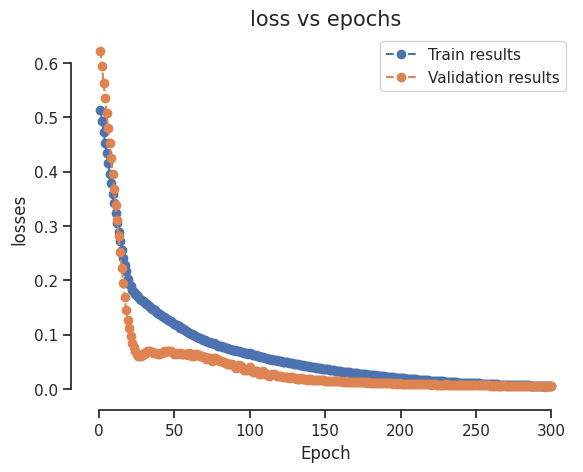

In [31]:
# Initialize network, loss function, and optimizer
critic = Critic().to(device)
loss_function =  nn.MSELoss()
optimizer = optim.Adam(critic.parameters(), lr=1e-4)
#scheduler = StepLR(optimizer, step_size = 10, gamma=0.1, verbose=True)
num_epochs = 300
train_losses, val_losses = run_training(critic, optimizer, loss_function, device, num_epochs, train_loader, val_loader)
plot("loss vs epochs", "losses", train_losses, val_losses)


torch.Size([50, 1])
(50,)


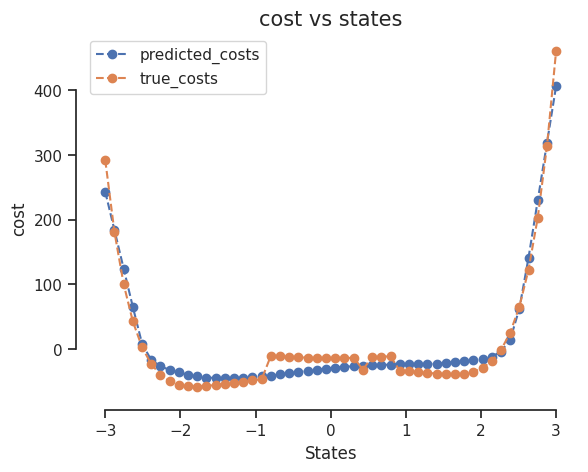

tensor([0.7897], grad_fn=<ViewBackward0>)
tensor([1.])


In [32]:
critic.eval()

predicted_costs = []

for state in initial_states:
    
    _cost = critic(state.to(device))
    cost = denormalize(_cost, min_costs, max_costs)
    
    predicted_costs.append(cost.item())
    
true_costs = denormalize(expected_costs, min_costs, max_costs)
states = denormalize(initial_states, min_states, max_states)

print(true_costs.shape)
print(np.array(predicted_costs).shape)

plot("cost vs states", "cost", predicted_costs, true_costs.detach().numpy(), legend = ["predicted_costs", "true_costs"], x_axis = states)

print(_cost)
print(expected_costs[-1])

## The Actor Network

In [33]:
class LargerActorNetwork(nn.Module):
    def __init__(self):
        super(LargerActorNetwork, self).__init__()
        self.fc1 = nn.Linear(1, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 128)
        self.fc7 = nn.Linear(128, 64)
        self.fc8 = nn.Linear(64, 1)
        #self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc5(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc6(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc7(x))
        x = self.fc8(x)
        x = torch.tanh(x)  # Assuming action range is [-1, 1]
        return x


Finished training after 31 seconds.


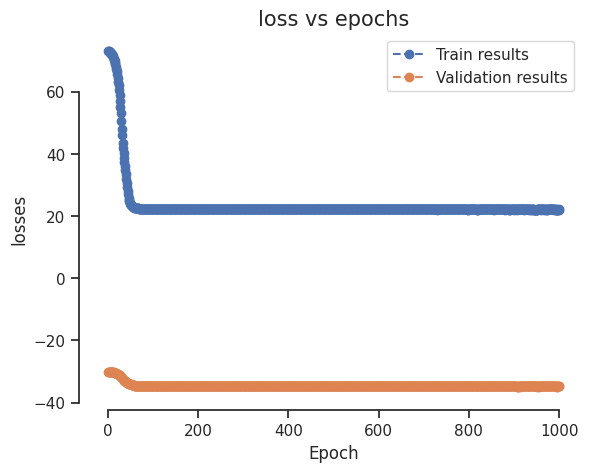

In [34]:
def inspect_gradients(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}:{param.grad}')


actor = LargerActorNetwork().to(device)
actor.train()
critic.eval()
optimizer = optim.Adam(actor.parameters(), lr=5e-5)
num_epochs = 1000

train_losses = []
val_losses = []

start_time = time.time()

# Training loop for the actor
for epoch in range(num_epochs):
    actor.train()
    train_loss = 0.0
    for norm_states, _ in train_loader:
        optimizer.zero_grad()
        
        actions = actor(norm_states)
        states = denormalize(norm_states, min_states, max_states)
        
        next_states = dynamics(states, actions, dt=0.5)  
        norm_next_states = normalize(next_states, min_states, max_states)     
        norm_state_value = critic(norm_next_states)
        state_value = denormalize(norm_state_value, min_costs, max_costs)
        
        q_values = running_cost(states, actions) + state_value
        loss = torch.mean(q_values)
        
        loss.backward()
        #inspect_gradients(critic)
        
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation step
    actor.eval()
    val_loss = 0.0
    with torch.no_grad():
        for norm_states, _ in val_loader:
            val_actions = actor(norm_states)
            val_states = denormalize(norm_states, min_states, max_states)
            
            next_states = dynamics(val_states, val_actions, dt=0.5)  
            norm_next_states = normalize(next_states, min_states, max_states)     
            norm_state_value = critic(norm_next_states)
            state_value = denormalize(norm_state_value, min_costs, max_costs)
            
            val_q_values = running_cost(val_states, val_actions) + state_value
            loss = torch.mean(val_q_values)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    #print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss:.4f}')
    
time_elapsed = np.round(time.time() - start_time, 0).astype(int)
print(f'Finished training after {time_elapsed} seconds.')
plot("loss vs epochs", "losses", train_losses, val_losses)

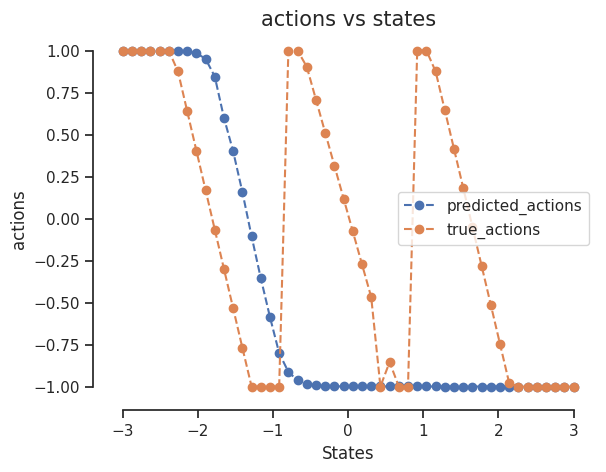

In [35]:
actor.eval()
critic.eval()

predicted_actions = []

for state in initial_states:
    _action = actor(state.to(device))
    predicted_actions.append(_action.item())
    
    
states = denormalize(initial_states, min_states, max_states)
plot("actions vs states", "actions", predicted_actions, opt_actions[:,0], x_axis = states, legend = ["predicted_actions", "true_actions"])

# print(_cost)
# print(expected_costs[-1])



# val = 730

# _state = initial_states[val].to(device)
# _cost = expected_costs[val].to(device)


# predicted_cost = critic(_state)
# print(predicted_cost)
# print(_cost)


# action = actor(initial_states[val])
# print(action)
# print(opt_actions[val])

# # value = torch.Tensor(x_traj[:20]).reshape(20,1).to(device)


# # actions = actor(value).cpu().detach().numpy()

# # print(optimal_u-actions.T)

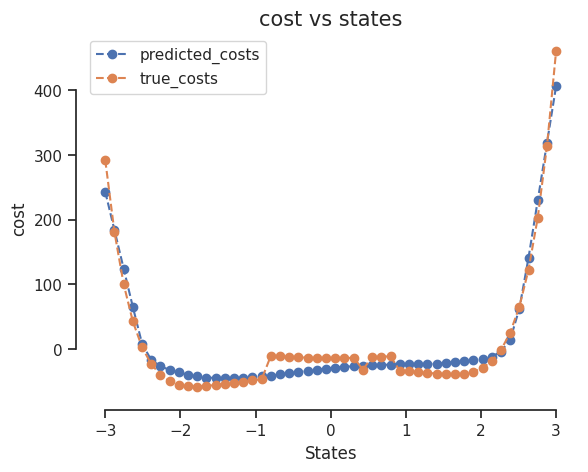

tensor([0.7897], grad_fn=<ViewBackward0>)
tensor([1.])


In [36]:
critic.eval()

predicted_costs = []

for state in initial_states:
    
    _cost = critic(state.to(device))
    cost = denormalize(_cost, min_costs, max_costs)
    
    predicted_costs.append(cost.item())
    
true_costs = denormalize(expected_costs, min_costs, max_costs)
states = denormalize(initial_states, min_states, max_states)

plot("cost vs states", "cost", predicted_costs, true_costs.detach().numpy(), legend = ["predicted_costs", "true_costs"], x_axis = states)

print(_cost)
print(expected_costs[-1])